In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization

In [2]:
tf.__version__

'2.3.0'

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Constants

In [4]:
BASE_PATH = 'Oxford-IIIT Pet\images'
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 7
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.75, 0.15, 0.1
BATCH_SIZE = 16
EPOCHS = 100

## Data Preparation

In [5]:
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(BASE_PATH, '*.jpg'))]

print(imageNames[::1000])
print(f"\nTotal number of image files: {len(imageNames)}")

['Abyssinian_1.jpg', 'Bengal_1.jpg', 'chihuahua_1.jpg', 'great_pyrenees_1.jpg', 'Maine_Coon_1.jpg', 'pug_1.jpg', 'scottish_terrier_1.jpg', 'wheaten_terrier_108.jpg']

Total number of image files: 7390


In [6]:
labels = [' '.join(name.split('_')[:-1]) for name in imageNames ]

print(np.unique(labels))
print(f"\nTotal number of unique labels: {len(np.unique(labels))}")

['Abyssinian' 'Bengal' 'Birman' 'Bombay' 'British Shorthair'
 'Egyptian Mau' 'Maine Coon' 'Persian' 'Ragdoll' 'Russian Blue' 'Siamese'
 'Sphynx' 'american bulldog' 'american pit bull terrier' 'basset hound'
 'beagle' 'boxer' 'chihuahua' 'english cocker spaniel' 'english setter'
 'german shorthaired' 'great pyrenees' 'havanese' 'japanese chin'
 'keeshond' 'leonberger' 'miniature pinscher' 'newfoundland' 'pomeranian'
 'pug' 'saint bernard' 'samoyed' 'scottish terrier' 'shiba inu'
 'staffordshire bull terrier' 'wheaten terrier' 'yorkshire terrier']

Total number of unique labels: 37


In [7]:
labelEncDict = {name : ind for ind, name in enumerate(np.unique(labels))}
labelEncDict

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British Shorthair': 4,
 'Egyptian Mau': 5,
 'Maine Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american bulldog': 12,
 'american pit bull terrier': 13,
 'basset hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english cocker spaniel': 18,
 'english setter': 19,
 'german shorthaired': 20,
 'great pyrenees': 21,
 'havanese': 22,
 'japanese chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint bernard': 30,
 'samoyed': 31,
 'scottish terrier': 32,
 'shiba inu': 33,
 'staffordshire bull terrier': 34,
 'wheaten terrier': 35,
 'yorkshire terrier': 36}

In [8]:
labelDecDict = {ind: name for name, ind in labelEncDict.items()}
labelDecDict

{0: 'Abyssinian',
 1: 'Bengal',
 2: 'Birman',
 3: 'Bombay',
 4: 'British Shorthair',
 5: 'Egyptian Mau',
 6: 'Maine Coon',
 7: 'Persian',
 8: 'Ragdoll',
 9: 'Russian Blue',
 10: 'Siamese',
 11: 'Sphynx',
 12: 'american bulldog',
 13: 'american pit bull terrier',
 14: 'basset hound',
 15: 'beagle',
 16: 'boxer',
 17: 'chihuahua',
 18: 'english cocker spaniel',
 19: 'english setter',
 20: 'german shorthaired',
 21: 'great pyrenees',
 22: 'havanese',
 23: 'japanese chin',
 24: 'keeshond',
 25: 'leonberger',
 26: 'miniature pinscher',
 27: 'newfoundland',
 28: 'pomeranian',
 29: 'pug',
 30: 'saint bernard',
 31: 'samoyed',
 32: 'scottish terrier',
 33: 'shiba inu',
 34: 'staffordshire bull terrier',
 35: 'wheaten terrier',
 36: 'yorkshire terrier'}

In [9]:
for i in labelEncDict.keys():
    print(f"{i} : {labels.count(i)}")

Abyssinian : 200
Bengal : 200
Birman : 200
Bombay : 200
British Shorthair : 200
Egyptian Mau : 200
Maine Coon : 200
Persian : 200
Ragdoll : 200
Russian Blue : 200
Siamese : 200
Sphynx : 200
american bulldog : 200
american pit bull terrier : 200
basset hound : 200
beagle : 200
boxer : 200
chihuahua : 200
english cocker spaniel : 200
english setter : 200
german shorthaired : 200
great pyrenees : 200
havanese : 200
japanese chin : 200
keeshond : 200
leonberger : 200
miniature pinscher : 200
newfoundland : 200
pomeranian : 200
pug : 200
saint bernard : 200
samoyed : 200
scottish terrier : 199
shiba inu : 200
staffordshire bull terrier : 191
wheaten terrier : 200
yorkshire terrier : 200


In [10]:
%%time

imageData = []

for name in tqdm(imageNames, desc = 'Loading image data', unit = ' images'):
    img = load_img(os.path.join(BASE_PATH, name), target_size = IMAGE_SIZE)
    imageData.append(img_to_array(img, dtype = 'uint8'))
    
imageData = np.array(imageData)
imageData.shape

Loading image data: 100%|████████████████████████████████████████████████████| 7390/7390 [01:12<00:00, 102.02 images/s]


Wall time: 1min 12s


(7390, 256, 256, 3)

In [11]:
labelsEncoded = list(map(lambda x : labelEncDict.get(x), labels))
labelsEncoded[::1000]

[0, 1, 17, 21, 6, 29, 32, 35]

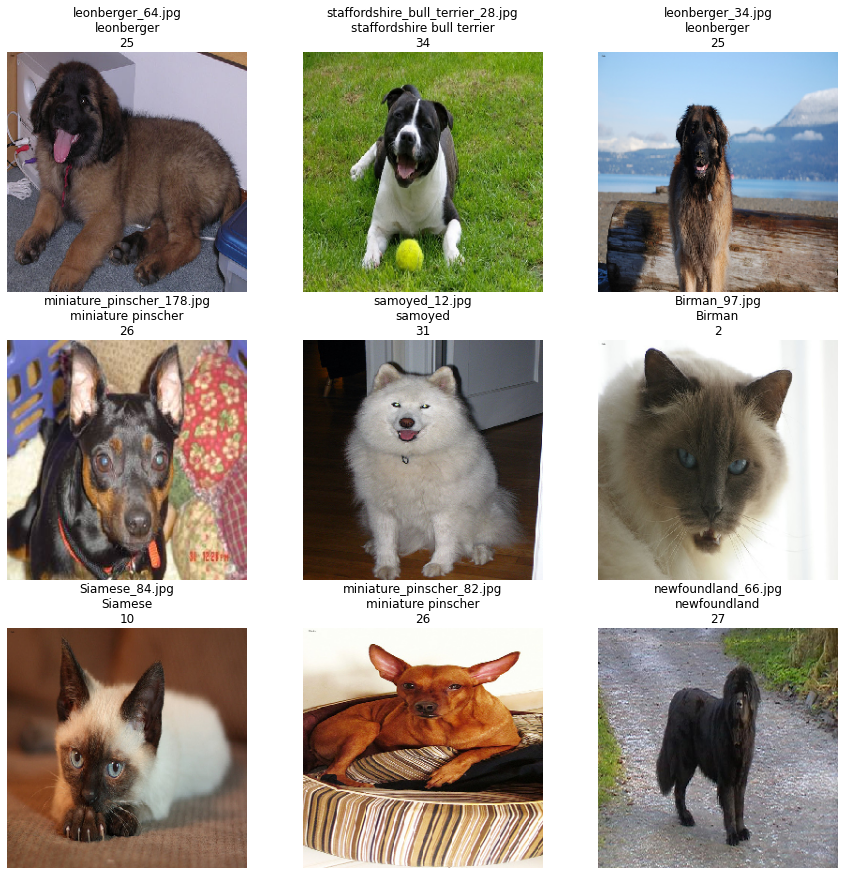

In [12]:
plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))

for i, imgIndex in enumerate(np.random.randint(0, len(imageNames), size = 9)):
  plt.subplot(3, 3, i + 1)
  plt.axis(False)
  plt.grid(False)
  plt.title(f'{imageNames[imgIndex]}\n{labels[imgIndex]}\n{labelsEncoded[imgIndex]}')
  plt.imshow(imageData[imgIndex])
plt.show()

In [13]:
X_tv, X_test, y_tv, y_test = train_test_split(imageData, 
                                                    labelsEncoded, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = labelsEncoded)

X_train, X_val, y_train, y_val = train_test_split(X_tv, 
                                                    y_tv, 
                                                    test_size = VAL_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = y_tv)

print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {len(y_train)}')
print(f'\nValidation Data: {X_val.shape}')
print(f'Validation Labels: {len(y_val)}')
print(f'\nTesting Data: {X_test.shape}')
print(f'Testing Labels: {len(y_test)}')

Training Data: (5653, 256, 256, 3)
Training Labels: 5653

Validation Data: (998, 256, 256, 3)
Validation Labels: 998

Testing Data: (739, 256, 256, 3)
Testing Labels: 739


https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow

In [14]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'reflect')
train_data = train_gen.flow(x = X_train, y = y_train, batch_size = BATCH_SIZE, shuffle = True)
len(train_data)

354

In [15]:
val_gen = ImageDataGenerator(rescale = 1./255)
val_data = val_gen.flow(x = X_val, y = y_val, batch_size = BATCH_SIZE, shuffle = True)
len(val_data)

63

In [16]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = X_test, y = y_test, batch_size = BATCH_SIZE)
len(test_data)

47

In [17]:
def plot_generator_images(gen, suptitle, nrows = 3, ncols = 3, figsize = (15, 15)):
    gen_data = gen.next()
    
    plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.suptitle(suptitle, fontsize = 20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.axis(False)
        plt.grid(False)
        
        plt.title(labelDecDict[gen_data[1][i]])
        plt.imshow(gen_data[0][i])

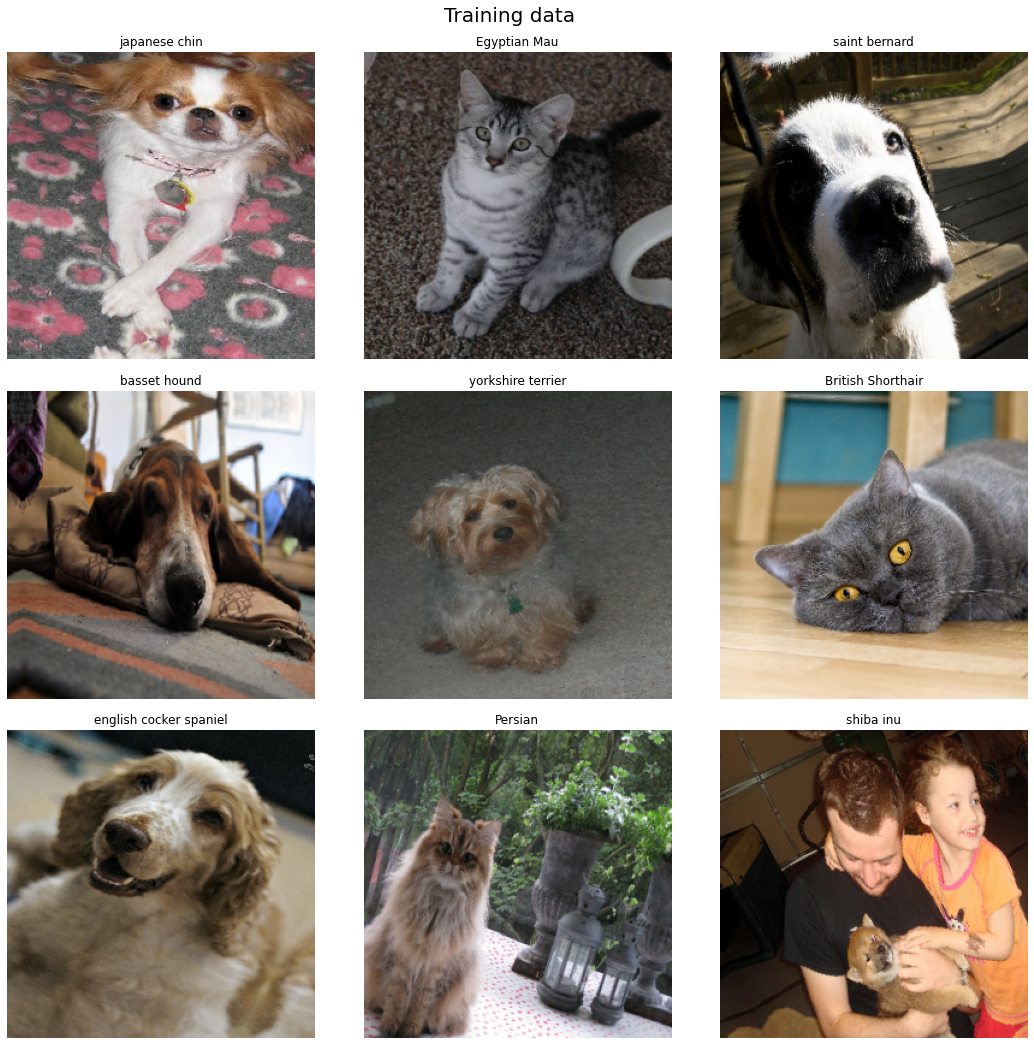

In [18]:
plot_generator_images(train_data, "Training data")

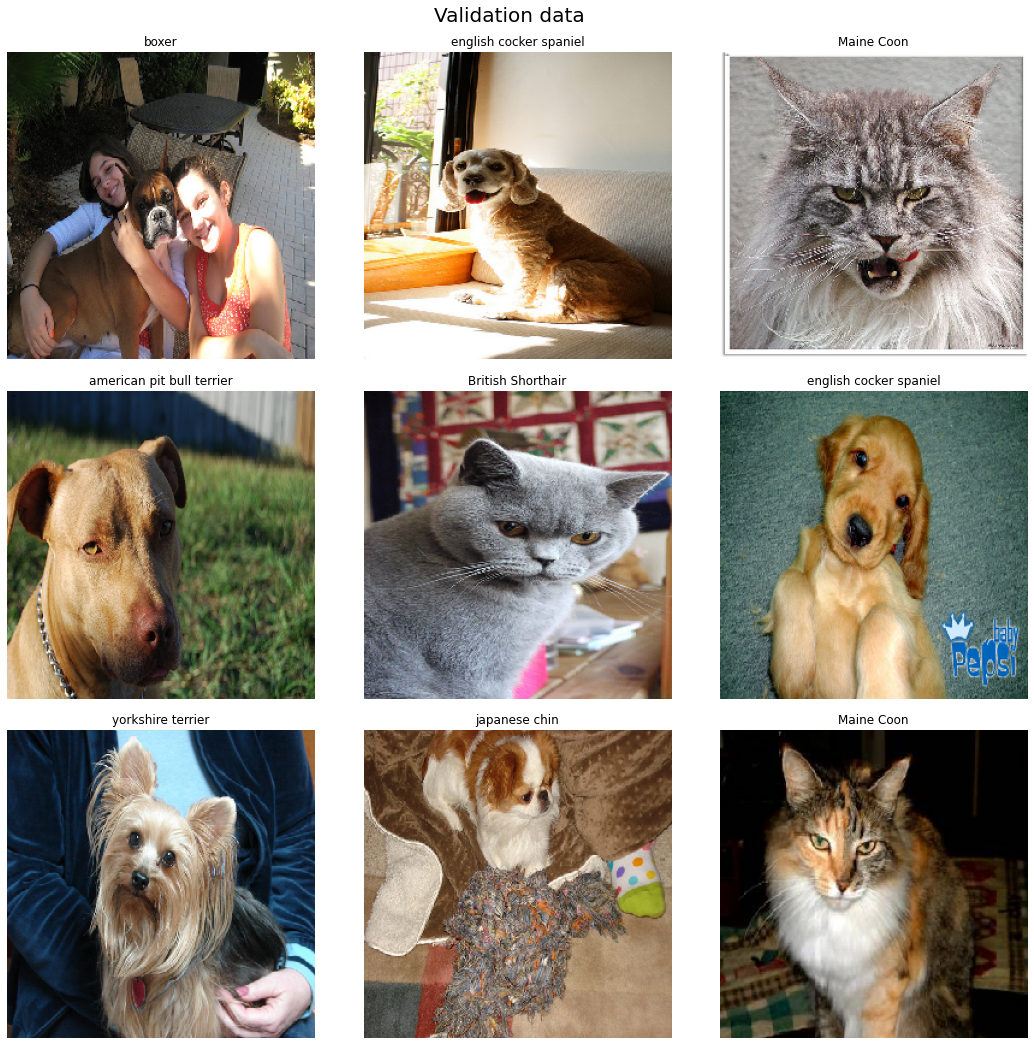

In [19]:
plot_generator_images(val_data, "Validation data")

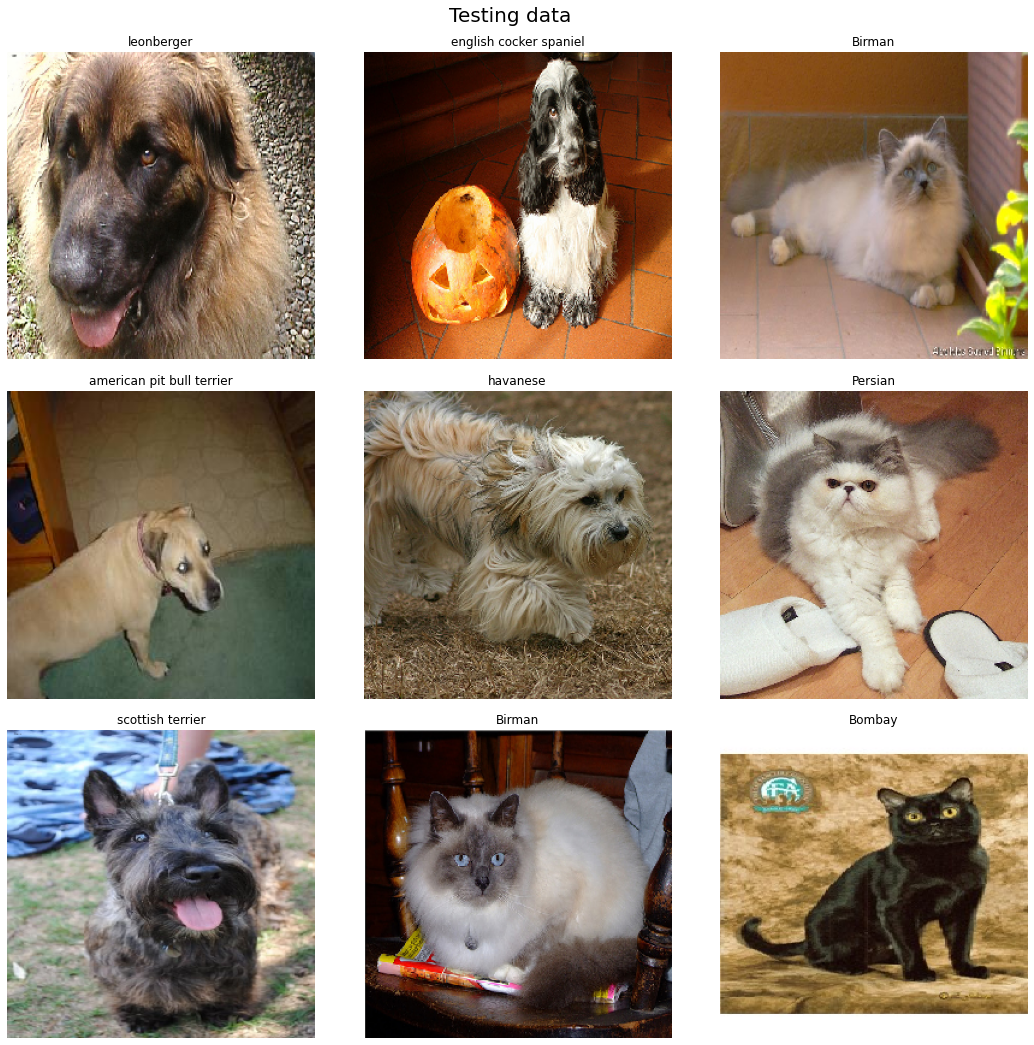

In [20]:
plot_generator_images(test_data, "Testing data")

In [21]:
model = Sequential([
    Conv2D(8, 3, padding = 'same', input_shape = (*IMAGE_SIZE, 3), activation = LeakyReLU(alpha = 0.5)),
    Conv2D(8, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(16, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    Conv2D(16, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(32, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    Conv2D(32, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    #Conv2D(256, 3, padding = 'same'),
    #Conv2D(256, 3, padding = 'same'),
    #MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dropout(0.3),
    Dense(1024, activation = LeakyReLU(alpha = 0.5)),
    Dense(len(labelEncDict), activation = 'softmax')
])

model.compile(optimizer = Adam(learning_rate = 0.001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4

In [22]:
%%time

earlyStop = EarlyStopping(monitor = 'val_loss', patience = 10, min_delta = 0.1)

history = model.fit(train_data, validation_data = val_data, epochs = EPOCHS, verbose = 1, callbacks = [earlyStop])

Epoch 1/100
354/354 [==============================] - 61s 171ms/step - loss: 10.9310 - accuracy: 0.0456 - val_loss: 11.6789 - val_accuracy: 0.0471
Epoch 2/100
354/354 [==============================] - 59s 167ms/step - loss: 5.1478 - accuracy: 0.0653 - val_loss: 4.5465 - val_accuracy: 0.0541
Epoch 3/100
354/354 [==============================] - 60s 170ms/step - loss: 3.6108 - accuracy: 0.0966 - val_loss: 5.3968 - val_accuracy: 0.0411
Epoch 4/100
354/354 [==============================] - 60s 169ms/step - loss: 3.3769 - accuracy: 0.1183 - val_loss: 5.1743 - val_accuracy: 0.0762
Epoch 5/100
354/354 [==============================] - 61s 171ms/step - loss: 3.3784 - accuracy: 0.1327 - val_loss: 3.4295 - val_accuracy: 0.1313
Epoch 6/100
354/354 [==============================] - 60s 171ms/step - loss: 3.3117 - accuracy: 0.1330 - val_loss: 4.0940 - val_accuracy: 0.1022
Epoch 7/100
354/354 [==============================] - 64s 180ms/step - loss: 3.2136 - accuracy: 0.1528 - val_loss: 3.6816

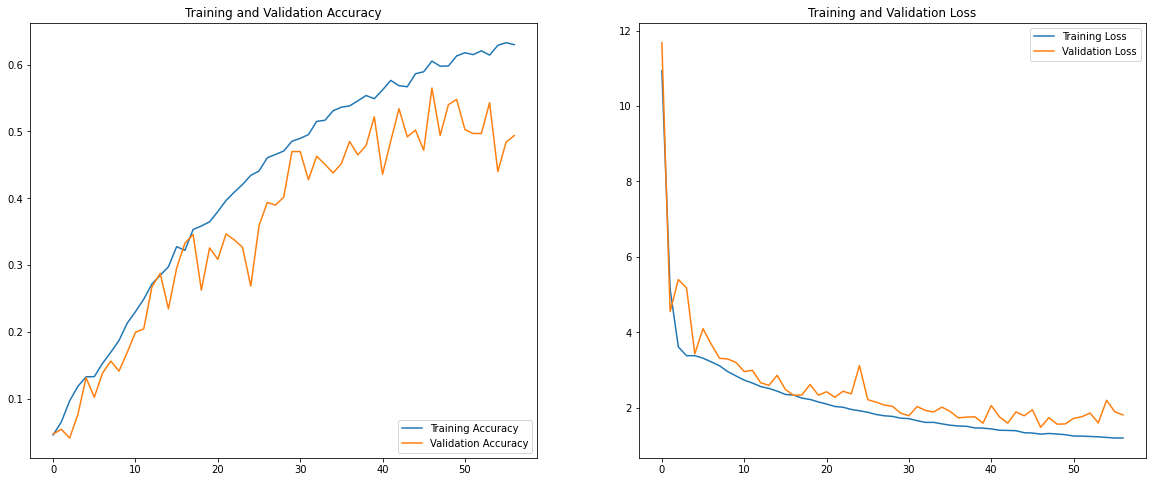

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()